In [3]:
# Step 1: Install Necessary Libraries
!pip install transformers torch torchvision


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\dmpoo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
# Step 2: Import Libraries
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification, ViTConfig
from PIL import Image

C:\Users\dmpoo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Step 3: Define Dataset Class
class RealVFakeDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []
        for label, subdir in enumerate(['real', 'fake']):
            subdir_path = os.path.join(directory, subdir)
            for img_file in os.listdir(subdir_path):
                if(img_file == "00000.jpg"):
                  print(img_file , label)
                self.images.append(os.path.join(subdir_path, img_file))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [6]:
# Step 4: Load Dataset and DataLoader
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# !unzip '/content/drive/MyDrive/ML Project - Dump/archive.zip'

In [7]:
train_dataset = RealVFakeDataset(r'C:\Users\dmpoo\OneDrive\Desktop\Faces-HQ\Final\train', transform)
valid_dataset = RealVFakeDataset(r'C:\Users\dmpoo\OneDrive\Desktop\Faces-HQ\Final\val', transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

00000.jpg 0


In [8]:
!pip install transformers datasets



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\dmpoo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
!nvidia-smi

Mon Dec  4 18:34:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 529.01       Driver Version: 529.01       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0    12W /  80W |      0MiB /  8188MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from datasets import load_dataset


dataset = load_dataset('imagefolder', data_files={'train': '/content/real_vs_fake/real-vs-fake/train/*/*',
                                                  'test': '/content/real_vs_fake/real-vs-fake/test/*/*',
                                                  'validation': '/content/real_vs_fake/real-vs-fake/val/*/*'})

In [10]:
# Step 5: Initialize Vision Transformer Model
from transformers import LevitForImageClassification, LevitConfig, LevitForImageClassificationWithTeacher
import torch

# Load pre-trained model configuration
config = LevitConfig.from_pretrained("facebook/levit-128S")
config.num_labels = 2  # Update number of classes

# Load pre-trained model with updated configuration
# model = LevitForImageClassification.from_pretrained("facebook/levit-128S", config=config, ignore_mismatched_sizes=True)
model = LevitForImageClassificationWithTeacher(config=config)

model.to(device)

LevitForImageClassificationWithTeacher(
  (levit): LevitModel(
    (patch_embeddings): LevitPatchEmbeddings(
      (embedding_layer_1): LevitConvEmbeddings(
        (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_layer_1): Hardswish()
      (embedding_layer_2): LevitConvEmbeddings(
        (convolution): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_layer_2): Hardswish()
      (embedding_layer_3): LevitConvEmbeddings(
        (convolution): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_layer_3): Hardswi

In [11]:
# Step 6: Define Loss Function and Optimizer
from torch.optim.lr_scheduler import StepLR

loss_function  = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


In [10]:
!pip install tqdm



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\dmpoo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
import time
import torch
from tqdm.notebook import tqdm


# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = 100 * correct / total
    return accuracy

# Training Loop Parameters
num_epochs = 8
early_stopping_patience = 10

# Tracking variables
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []
min_val_loss = float('inf')
epochs_no_improve = 0

# Best model checkpoint initialization
best_model_state = {
    'epoch': 0,
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'loss': float('inf'),
}

# Training Loop
for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    total_loss, total_accuracy = 0, 0

    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += calculate_accuracy(outputs, labels)

        # Calculate and print ETA
        elapsed_time = time.time() - start_time
        steps_per_epoch = len(train_loader)
        remaining_steps = steps_per_epoch - (step + 1)
        eta = (elapsed_time / (step + 1)) * remaining_steps

        if step % 100 == 0:  # Print progress every 10 steps
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{steps_per_epoch}], Loss: {loss.item():.4f}, ETA: {eta:.2f} sec")

    average_loss = total_loss / len(train_loader)
    average_accuracy = total_accuracy / len(train_loader)
    training_losses.append(average_loss)
    training_accuracies.append(average_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {average_loss:.4f} Accuracy: {average_accuracy:.2f}%")

    # Validation Step
    model.eval()
    valid_loss, valid_accuracy = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = loss_function(outputs, labels)
            valid_loss += loss.item()
            valid_accuracy += calculate_accuracy(outputs, labels)
    average_valid_loss = valid_loss / len(valid_loader)
    average_valid_accuracy = valid_accuracy / len(valid_loader)
    validation_losses.append(average_valid_loss)
    validation_accuracies.append(average_valid_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {average_valid_loss:.4f} Accuracy: {average_valid_accuracy:.2f}%")

    # Checkpoint and Early Stopping Logic
    if average_valid_loss < min_val_loss:
        min_val_loss = average_valid_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        torch.save(best_model_state, "best_model_teacher_scratch_LeViT.pth")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

    # Update learning rate scheduler if used
    # scheduler.step()

# Save the final model if necessary
torch.save(model.state_dict(), "final_model_TEACHER_scartch_LeViT_state.pth")


Epoch [1/8], Step [1/3702], Loss: 0.6728, ETA: 65137.44 sec
Epoch [1/8], Step [101/3702], Loss: 0.6650, ETA: 2438.62 sec
Epoch [1/8], Step [201/3702], Loss: 0.7291, ETA: 2022.73 sec
Epoch [1/8], Step [301/3702], Loss: 0.7399, ETA: 1815.48 sec
Epoch [1/8], Step [401/3702], Loss: 0.6652, ETA: 1667.66 sec
Epoch [1/8], Step [501/3702], Loss: 0.7212, ETA: 1557.33 sec
Epoch [1/8], Step [601/3702], Loss: 0.6723, ETA: 1472.95 sec
Epoch [1/8], Step [701/3702], Loss: 0.6902, ETA: 1402.89 sec
Epoch [1/8], Step [801/3702], Loss: 0.7021, ETA: 1335.02 sec
Epoch [1/8], Step [901/3702], Loss: 0.6901, ETA: 1278.41 sec
Epoch [1/8], Step [1001/3702], Loss: 0.6827, ETA: 1223.59 sec
Epoch [1/8], Step [1101/3702], Loss: 0.6730, ETA: 1168.31 sec
Epoch [1/8], Step [1201/3702], Loss: 0.6701, ETA: 1121.10 sec
Epoch [1/8], Step [1301/3702], Loss: 0.6588, ETA: 1073.31 sec
Epoch [1/8], Step [1401/3702], Loss: 0.6958, ETA: 1024.52 sec
Epoch [1/8], Step [1501/3702], Loss: 0.6365, ETA: 974.67 sec
Epoch [1/8], Step [1

In [13]:
print("TRAINING ACCURACIES",training_accuracies)

print("VALIDATION ACCURACIES",validation_accuracies)


TRAINING ACCURACIES [56.78893541028873, 58.93379704664145, 61.94812113572243, 72.38598505312444, 81.99996998619365, 87.75699321687976, 90.96556290893811, 92.91261480280929]
VALIDATION ACCURACIES [59.11744505494506, 59.89010989010989, 66.32898351648352, 76.6354739010989, 86.83035714285714, 90.38461538461539, 92.42359203296704, 93.56541895604396]


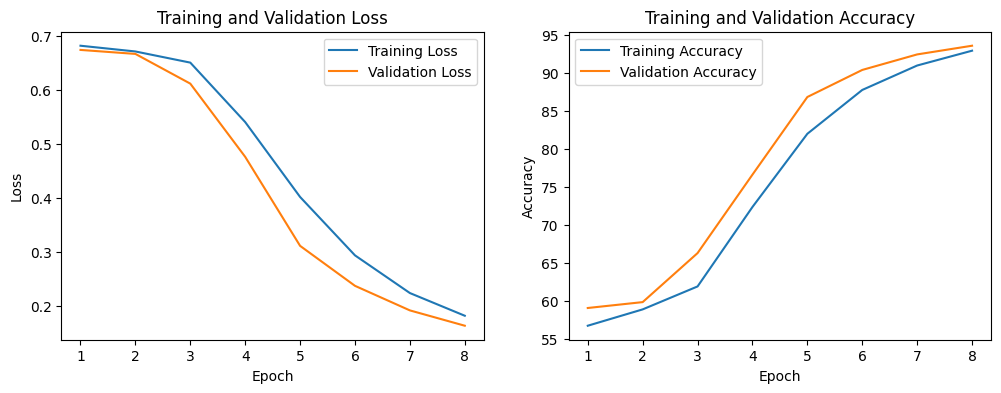

In [14]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), training_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [15]:
# Continuation from the previous code

# Step 8: Define a Function to Calculate Accuracy
def calculate_accuracy(model, data_loader, device):
    correct_pred = 0
    total_pred = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)

    return correct_pred / total_pred

# Step 9: Load Test Dataset and DataLoader
test_dataset = RealVFakeDataset(r'C:\Users\dmpoo\OneDrive\Desktop\Faces-HQ\Final\test', transform)
test_loader = DataLoader(test_dataset, batch_size=32)

# Step 10: Evaluate the Model on Test Set
model.eval()
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy * 100}%")

# Optional: Get Predictions for Individual Test Images
predictions = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Print some predictions
print("Some predictions:", predictions[:10])


Test Accuracy: 93.43477886024657%
Some predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [16]:
test_dataset = RealVFakeDataset(r'C:\Users\dmpoo\OneDrive\Desktop\Faces-HQ\Final\test', transform)
test_loader = DataLoader(test_dataset, batch_size=32)  # Adjust batch size as needed


In [17]:
model.eval()
predictions = []
actual_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

In [18]:
import numpy as np
# Print predictions and actual labels
print("Predictions:", predictions)
print("Actual labels:", actual_labels)

# Calculate accuracy
accuracy = sum(np.array(predictions) == np.array(actual_labels)) / len(actual_labels)
print(f"Accuracy: {accuracy * 100}%")

# Confusion Matrix (optional)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_labels, predictions)
print("Confusion Matrix:\n", cm)


Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [42]:
!pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/4e/ba/ce9bd1cd4953336a0e213b29cb80bb11816f2a93de8c99f88ef0b446ad0c/scikit_learn-1.3.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.2 MB 1.4 MB/s eta 0:00:07
   - -------------------------------------- 0.3/9.2 MB 4.3 MB/s eta 0:00:03
   ---- ----------------------------------- 1.0/9.2 MB 8.8 MB/s eta 0:00:01
   ---------- ----------------------------- 2.5/9.2 MB 16.0 MB/


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\dmpoo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [19]:
from sklearn.metrics import confusion_matrix

# Assuming predictions and actual_labels are already defined
cm = confusion_matrix(actual_labels, predictions)


In [20]:
!pip install seaborn matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\dmpoo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


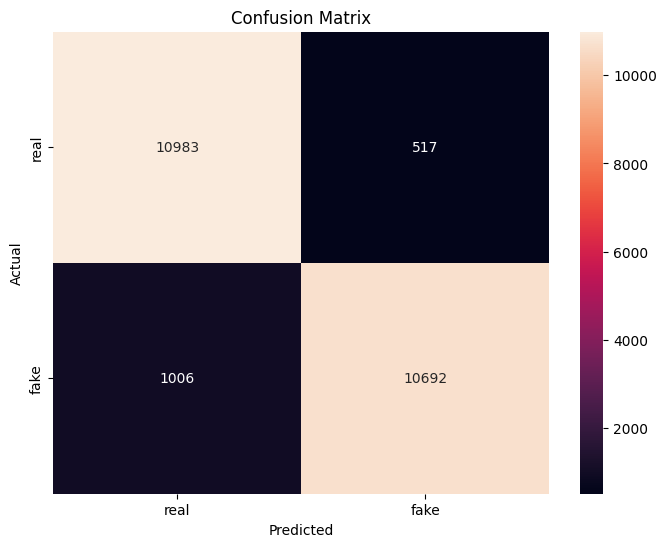

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
class_labels = ['real','fake']

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [22]:
from PIL import Image
from torchvision import transforms

# Transformations used during training, without augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and transform the image
img = Image.open(r"C:\Users\dmpoo\Downloads\SG2Images\seed0615.png")
img = transform(img).unsqueeze(0)  # Add batch dimension
img = img.to(device)  # Move to the same device as your model
with torch.no_grad():
    outputs = model(img).logits
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted.item()

# Output the result
print(f"Predicted class: {predicted_class}")
# You can map this to a class name if you have a label map

Predicted class: 1


In [50]:
!unzip '/content/test.zip'

Archive:  /content/test.zip
  inflating: test/seed1454.png       
  inflating: test/seed1458.png       
  inflating: test/seed1461.png       
  inflating: test/seed1462.png       
  inflating: test/seed1463.png       
  inflating: test/seed1464.png       
  inflating: test/seed1465.png       
  inflating: test/seed1468.png       
  inflating: test/seed1471.png       
  inflating: test/seed1472.png       
  inflating: test/seed1477.png       
  inflating: test/seed1478.png       
  inflating: test/seed1480.png       
  inflating: test/seed1522.png       
  inflating: test/seed1523.png       
  inflating: test/seed1524.png       
  inflating: test/seed1527.png       
  inflating: test/seed1528.png       
  inflating: test/seed1529.png       
  inflating: test/seed1530.png       
  inflating: test/seed1531.png       
  inflating: test/seed1532.png       
  inflating: test/seed1533.png       
  inflating: test/seed1535.png       
  inflating: test/seed1536.png       
  inflating: test/seed

In [23]:
import os

directory = r'C:\Users\dmpoo\OneDrive\Desktop\Faces-HQ\styleGan2'
image_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]


In [24]:
real=0
fake=0
for image_path in image_paths:
    # Load and transform the image
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0)  # Add batch dimension
    img = img.to(device)  # Move to the same device as your model
    class_bale =['real', 'fake']
    # Model inference
    with torch.no_grad():
        outputs = model(img).logits
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
        if predicted_class == 0:
            real+=1
        else:
            fake+=1

    # Output the result
    # print(f"Image: {image_path}, Predicted class: {class_bale[predicted_class]}")
    # Optionally, map 'predicted_class' to a human-readable class name
print(f"Real count: {real} Fake count : {fake}")

Real count: 1556 Fake count : 2699


In [ ]:
model